## Concatenate WUI fires

In [1]:
import pandas as pd

# Read each CSV file into a DataFrame
tubbs_df = pd.read_csv("Tubbs_original.csv")
thomas_df = pd.read_csv("Thomas_original.csv")
camp_df = pd.read_csv("Camp_original.csv")
kincade_df = pd.read_csv("Kincade_original.csv")
glass_df = pd.read_csv("Glass_original.csv")

# Concatenate the DataFrames
concatenated_df = pd.concat([tubbs_df, thomas_df, camp_df, kincade_df, glass_df])

# Shuffle the rows
concatenated_df = concatenated_df.sample(frac=1).reset_index(drop=True)

In [5]:
concatenated_df.to_csv("concatenated_df.csv", index=False)

### Logistic Regression

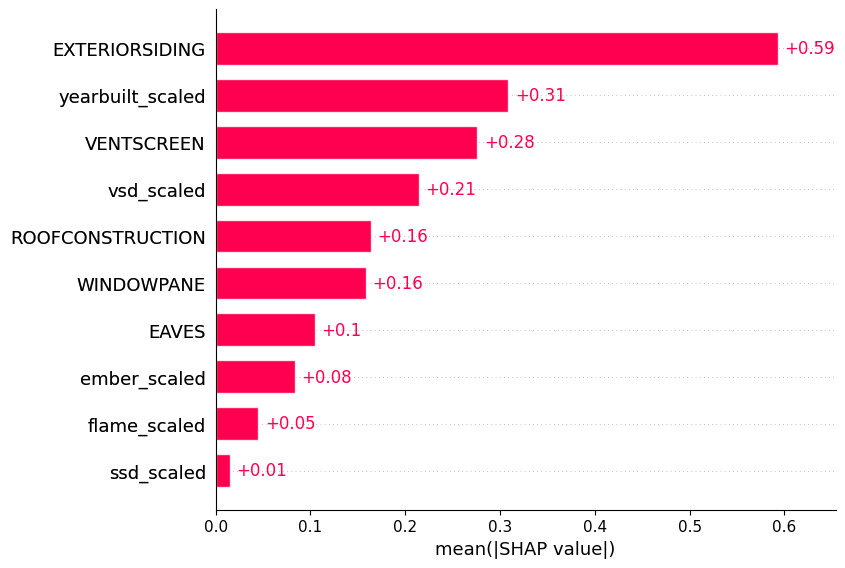

In [11]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load model
with open("logit_v0_using_numeric_features.pkl", "rb") as file:
    model_logit = pickle.load(file)

# Define X_test, y_test, X_train, y_train
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

def treat_encoded_shap_vals(sv, X, data_dict):
    shap_values = sv
    # reconstruct the original dataset before encoding
    X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
    X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled'] 
    
    X_cat_original = data_dict["X_encoder"].inverse_transform(X[X_cat_cols])
    X_cat_original = pd.DataFrame(X_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
    X_num_original = X.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
    X_original = X_cat_original.join(X_num_original)
    feature_names = X_cat_original.columns

    # get number of unique classes within each categorical data
    n_categories = []
    for f in feature_names[:-1]:
        n = X_cat_original[f].nunique()
        n_categories.append(n)

    # separating the shap values for categorical and numerical data
    # this part needs to be done according to the order of the 
    # features in axis=1.
    shap_values_cat = shap_values.values[:, :-len(X_num_cols)]
    shap_values_num = shap_values.values[:, -len(X_num_cols):]

    # replace the aggregated shap values for catgorical features
    new_shap_values_cat = []
    for values in shap_values_cat:        
        values_split = np.split(values , np.cumsum(n_categories))
        values_sum = [sum(vs) for vs in values_split]
        new_shap_values_cat.append(values_sum)
        
    new_shap_values_cat = np.array(new_shap_values_cat)
    new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
    shap_values.values = new_shape_values
    shap_values.data = X_original.values
    shap_values.feature_names = feature_names.to_list() + X_num_cols
    
    return shap_values, X_original 

# best model estimator
best_model_logit = model_logit['grid_search'].best_estimator_

# Create a SHAP explainer using the best model
explainer = shap.Explainer(best_model_logit, masker=X_test)

# Calculate SHAP values 
shap_values_exp = explainer(X_test)
shap_values, X_test_original = treat_encoded_shap_vals(shap_values_exp, X_test, data_dict)

shap.plots.bar(shap_values, max_display=20)


### Random Forest

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


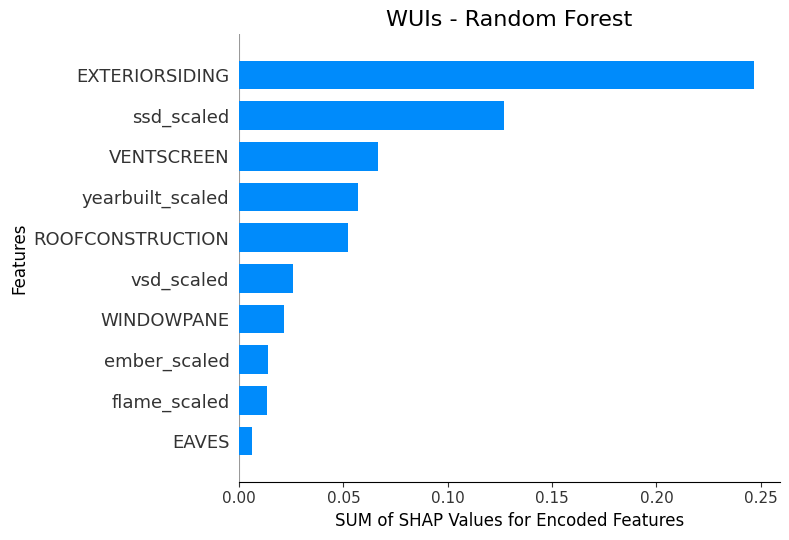

In [10]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load Random Forest model
with open("rf_v0_using_numeric_features.pkl", "rb") as file:
    model_rf = pickle.load(file)

# define X_test, y_test
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

# model_rf is RandomizedSearchCV object containing RandomForestClassifier
best_model = model_rf.best_estimator_

# Create a SHAP explainer using the best model
explainer_rf = shap.Explainer(best_model)

# Calculate SHAP values 
shap_values_rf = explainer_rf(X_test)

# Calculate the sum of SHAP values for each feature
sum_shap_values = np.sum(np.abs(shap_values_rf.values), axis=2)


# Create a DataFrame to store the sum of SHAP values
sum_shap_values_df = pd.DataFrame(sum_shap_values, columns=X_test.columns)

# Define the aggregate features
aggregate_features = {
    'ROOFCONSTRUCTION': ['Fire Resistant', 'Combustible','Asphalt', 'Concrete', 'Metal', 'Other', 'Tile', 'Wood'],
    'EAVES': ['Enclosed', 'No Eaves', 'Unenclosed', 'Not Applicable'],
    'VENTSCREEN': ['Mesh Screen <= 1/8"', 'Mesh Screen > 1/8"', 'No Vents', 'Unscreened', 'Screened'],
    'EXTERIORSIDING': ['Combustible','Stucco/Brick/Cement','Ignition Resistant','Vinyl', 'Stucco Brick Cement', 'Metal', 'Other', 'Wood', 'Fire Resistant'],
    'WINDOWPANE': ['Multi Pane', 'No Windows', 'Single Pane']
}


for feature in aggregate_features:
    categories = aggregate_features[feature]
    column_names = [f"{feature}_{category}" for category in categories]
    sum_shap_values_df[feature] = sum_shap_values_df[column_names].sum(axis=1, skipna=True)
    sum_shap_values_df.drop(columns=column_names, inplace=True)

# Create a SHAP summary plot with aggregated features
shap.summary_plot(sum_shap_values_df, feature_names=sum_shap_values_df.columns, plot_type="bar", show=False)
plt.title("WUIs - Random Forest", fontsize=16)
plt.xlabel("SUM of SHAP Values for Encoded Features", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()


## XGBoost

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[13:11:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:12:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 6854/6870 [05:39<00:00]        

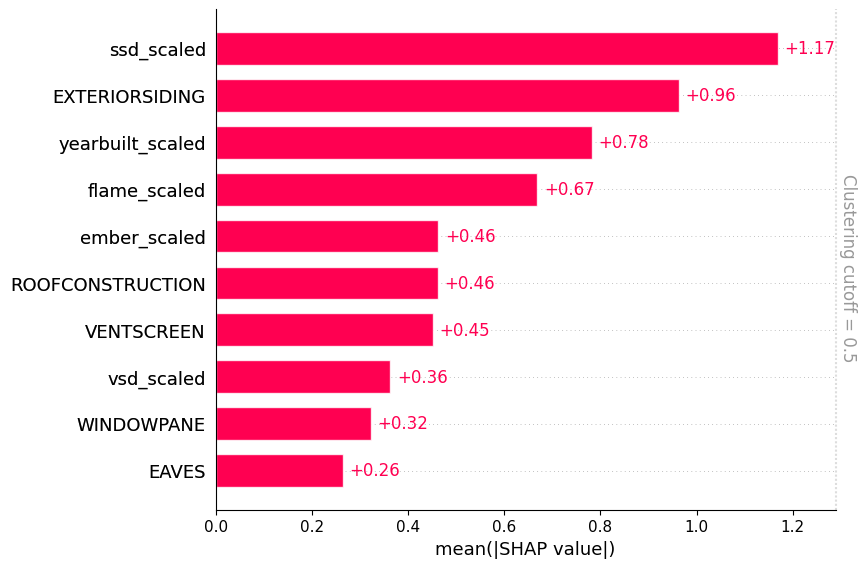

In [1]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# Read datasets
with open("concatenated_df_ohe_targets_train_test_num_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)
    
# Load Random Forest model
with open("xgb_v0_using_numeric_features.pkl", "rb") as file:
    model_xgb = pickle.load(file)

# Define X_test, y_test, X_train, y_train
X_test, y_test = data_dict["X_test"], data_dict["y_test"]
X_train, y_train = data_dict["X_train"], data_dict["y_train"]

def treat_encoded_shap_vals(sv, X, data_dict):
    shap_values = sv
    # reconstruct the original dataset before encoding
    X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
    X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled'] 
    
    X_cat_original = data_dict["X_encoder"].inverse_transform(X[X_cat_cols])
    X_cat_original = pd.DataFrame(X_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
    X_num_original = X.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
    X_original = X_cat_original.join(X_num_original)
    feature_names = X_cat_original.columns

    # get number of unique classes within each categorical data
    n_categories = []
    for f in feature_names[:-1]:
        n = X_cat_original[f].nunique()
        n_categories.append(n)

    # separating the shap values for categorical and numerical data
    # this part needs to be done according to the order of the 
    # features in axis=1.
    shap_values_cat = shap_values.values[:, :-len(X_num_cols)]
    shap_values_num = shap_values.values[:, -len(X_num_cols):]

    # replace the aggregated shap values for catgorical features
    new_shap_values_cat = []
    for values in shap_values_cat:        
        values_split = np.split(values , np.cumsum(n_categories))
        values_sum = [sum(vs) for vs in values_split]
        new_shap_values_cat.append(values_sum)
        
    new_shap_values_cat = np.array(new_shap_values_cat)
    new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
    shap_values.values = new_shape_values
    shap_values.data = X_original.values
    shap_values.feature_names = feature_names.to_list() + X_num_cols
    
    return shap_values, X_original 

# best model estimator
best_model_xgb = model_xgb.best_estimator_

# Create a SHAP explainer using the best model
explainer = shap.Explainer(best_model_xgb, masker=X_test)

# Calculate SHAP values 
shap_values_exp = explainer(X_test)
shap_values, X_test_original = treat_encoded_shap_vals(shap_values_exp, X_test, data_dict)

# Convert shap_values to numpy array
shap_values_array = shap_values.values

# Apply clustering to SHAP values using the 'euclidean' metric
clustering = shap.utils.hclust(shap_values_array, metric='euclidean')

# Get the feature order based on the clustering
feature_order = np.argsort(clustering.flatten())

# Create a SHAP bar plot with the filtered features
shap.plots.bar(shap_values, clustering=clustering, max_display=20)

## Concatenating and testing by fire

/home/maryamz/DINS_data_preparation/data/WUI_fires/Tubbs_original.csv
Read, feature engineer, and split between train and test
Imputation based on location information
No encoding for the features!
Normalize the required features and drop extra information!
/home/maryamz/DINS_data_preparation/data/WUI_fires/Camp_original.csv
Read, feature engineer, and split between train and test
Imputation based on location information
No encoding for the features!
Normalize the required features and drop extra information!
/home/maryamz/DINS_data_preparation/data/WUI_fires/Glass_original.csv
Read, feature engineer, and split between train and test
Imputation based on location information
No encoding for the features!
Normalize the required features and drop extra information!
/home/maryamz/DINS_data_preparation/data/WUI_fires/Kincade_original.csv
Read, feature engineer, and split between train and test
Imputation based on location information
No encoding for the features!
Normalize the required feat

[19:31:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "ccp_alpha", "max_features", "min_impurity_decrease" } are not used.

[19:35:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 99%|===================| 1094/1101 [00:13<00:00]        

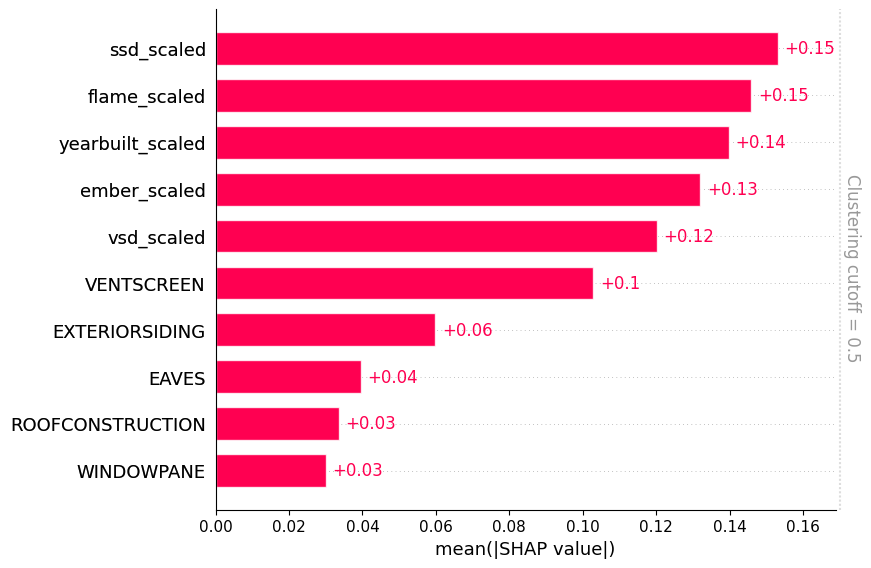

In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder
import pickle
import shap
import xgboost as xgb
from sklearn.utils import shuffle
from utils.preprocessing import data_preprocessing_pipeline
from sklearn.model_selection import train_test_split

# ML related imports
from xgboost import XGBClassifier, DMatrix
from sklearn.preprocessing import LabelEncoder
import pickle
import shap

fire_list = ["Tubbs", "Camp", "Glass", "Kincade", "Thomas"]
all_X_train = pd.DataFrame()
all_y_train = pd.DataFrame()
all_X_test = pd.DataFrame()
all_y_test = pd.DataFrame()
for i, case in enumerate(fire_list):
    data_dict = data_preprocessing_pipeline(case, 
                                            renew_data=True, 
                                            encode_data=False, 
                                            scale_data=True,
                                            task_type="binary")
    tmp_x_train = data_dict["X_train"]
    tmp_x_train["fire_id"] = i
    tmp_y_train = data_dict["y_train"]
    all_X_train = pd.concat([all_X_train, tmp_x_train], axis=0)
    all_y_train = pd.concat([all_y_train, tmp_y_train], axis=0)

    tmp_x_test = data_dict["X_test"]
    tmp_x_test["fire_id"] = i
    tmp_y_test = data_dict["y_test"]
    all_X_test = pd.concat([all_X_test, tmp_x_test], axis=0)
    all_y_test = pd.concat([all_y_test, tmp_y_test], axis=0)

all_X_train.drop("fire_id", axis=1, inplace=True)
all_X_train = shuffle(all_X_train)
all_y_train = shuffle(all_y_train)

all_X_test = shuffle(all_X_test)
all_X_test = shuffle(all_X_test)

# Assuming X_train contains the same columns as your dataset
categorical_columns = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    all_X_train[col] = label_encoders[col].fit_transform(all_X_train[col])
    all_X_test[col] = label_encoders[col].transform(all_X_test[col])
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_X_train, all_y_train, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=0.9,
                          max_features="sqrt",
                          min_impurity_decrease=0,
                          ccp_alpha=0.01,
                          random_state=42)

model.fit(X_train, y_train.values.ravel())

# Define the explainer using the entire training dataset
explainer = shap.Explainer(model, X_train)

#test by fire
test_case = "Glass"
fire_id = 0
X_test = all_X_test.query("fire_id==0")
X_test.drop("fire_id", axis=1, inplace=True)

# Calculate SHAP values 
shap_values = explainer(X_test)

# Extract SHAP values from the Explanation object
shap_values_array = shap_values.values

# Apply hierarchical clustering to SHAP values
clustering = shap.utils.hclust(shap_values_array, metric='euclidean')

# Get the feature order based on the clustering
feature_order = np.argsort(clustering.flatten())

# Create a SHAP bar plot with clustering
shap.plots.bar(shap_values, clustering=clustering, max_display=20)

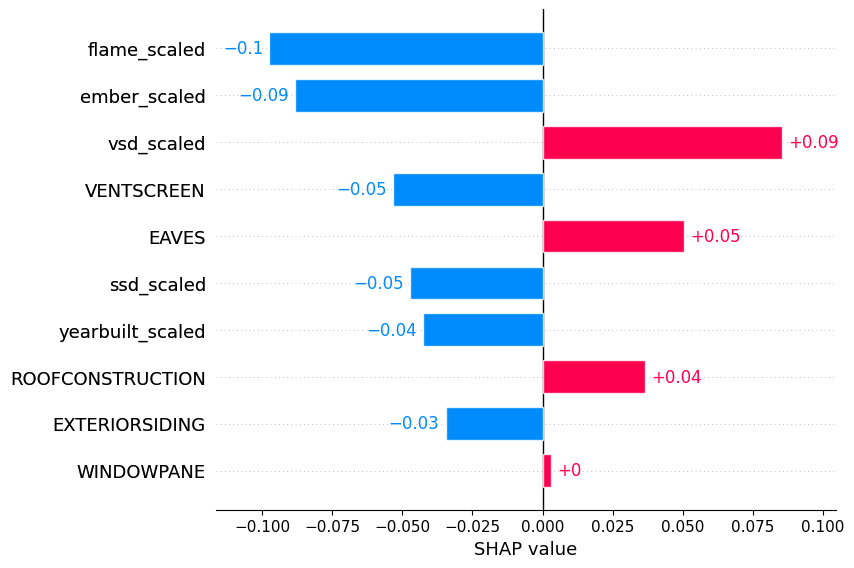

In [25]:
shap_values_partition = explainer(X_test[:100])
shap.plots.bar(shap_values_partition[0], max_display=20)

### CatBoost

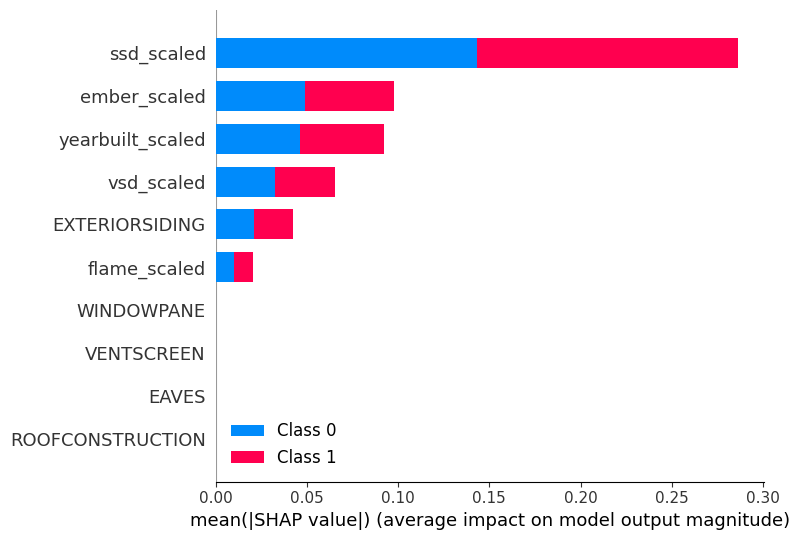

In [13]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost as cb
import pickle
import shap


# Read datasets
with open("concatenated_df_ohe_targets_train_test_cat_ready_data_binary.pkl", "rb") as file:
    data_dict = pickle.load(file)

X_train = data_dict['X_train']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_test = data_dict['y_test']


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.to_numpy())
y_test_encoded = np.argmax(y_test.to_numpy(), axis=0)


# Drop 'X', 'Y', and 'Z' columns
#X_train = X_train.drop(['X', 'Y', 'Z'], axis=1)
#X_test = X_test.drop(['X', 'Y', 'Z'], axis=1)

cat_features = ['ROOFCONSTRUCTION', 'EAVES', 'VENTSCREEN', 'EXTERIORSIDING', 'WINDOWPANE']

def train_model_with_adaptive_lr(X_train, y_train, cat_features, iterations=100, start_lr=0.01, end_lr=0.1, depth=6):
    model = cb.CatBoostClassifier(iterations=iterations, learning_rate=start_lr, depth=depth, loss_function='MultiClass')
    
    # Define the learning rate schedule
    lr_schedule = [start_lr + (end_lr - start_lr) * i / iterations for i in range(iterations)]
    
    for i, lr in enumerate(lr_schedule):
        model.learning_rate = lr
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
    
    return model

model = train_model_with_adaptive_lr(X_train, y_train_encoded, cat_features, iterations=100, start_lr=0.01, end_lr=0.1, depth=6)


# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10) 